# **Audiobook Purchase Prediction**
## **Project description**

The given data comes from an Audiobook app. Each customer in the database has made a purchase at least once, that's why he/she is in the database. We want to create an algorithm based on our available data that can predict if a customer will buy again from the Audiobook company.

The main idea is that if a customer has a low probability of coming back, there is no reason to spend any money on advertizing to him/her. If we can focus our efforts ONLY on customers that are likely to convert again, we can make great savings. Moreover, this model can identify the most important metrics for a customer to come back again. Identifying new customers creates value and growth opportunities.

the data is summarized in a .csv file.

### **Variables:**

*   Customer ID
*   Book length in mins_avg (average of all purchases)
*   Book length in minutes_sum (sum of all purchases. If equal to Book length in mins_avg, thus customers made 1 purchase only.)
*   Price Paid_avg (average of all purchases)
*   Price paid_sum (sum of all purchases. If equal to Price Paid_avg, thus customers made 1 purchase only.)
*   Review (Boolean variable. 1 = Customer left a review)
*   Review (out of 10)
*   Total minutes listened
*   Completion (from 0 to 1) => Total minutes listened / Total lengths of books the person has purchased
*   Support requests (number)
*   Last visited minus purchase date (in days) => measures the difference between the last time a person interacted with the platform and the first purchase date. The bigger the difference, the bigger the engagement.

So these variables are going to be the inputs of our model (excluding customer ID, as it is completely arbitrary).

### **Targets:**

The targets are a Boolean variable (0 or 1). We are taking a period of 2 years in our inputs, and the next 6 months as targets.<br />
In fact, we are predicting if based on the last 2 years of activity and engagement, a customer will convert in the next 6 months. If they do not convert after 6 months, chances are they have gone to a competitor or di not like the Audiobook way of digesting information.

**This is a supervised classification problem with two classes: won't buy and will buy, represented by 0s and 1s.**

In [ ]:
# import required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

In [ ]:
# import data
column_names = ["customer_id", "book_length_mins_avg", "book_length_mins_sum",
                "price_paid_avg", "price_paid_sum", "left_review", "review",
                "total_mins_listened", "completion", "support_requests",
                "last_visited_minus_purchase_date", "label"]

audiobook_data = pd.read_csv("audiobooks-data.csv", header=None)
audiobook_data.columns = column_names
audiobook_data.head()

,customer_id,book_length_mins_avg,book_length_mins_sum,price_paid_avg,price_paid_sum,left_review,review,total_mins_listened,completion,support_requests,last_visited_minus_purchase_date,label
0,994,1620.0,1620,19.73,19.73,1,10.00,0.99,1603.8,5,92,0
1,1143,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,0,0
2,2059,2160.0,2160,5.33,5.33,0,8.91,0.00,0.0,0,388,0
3,2882,1620.0,1620,5.96,5.96,0,8.91,0.42,680.4,1,129,0
4,3342,2160.0,2160,5.33,5.33,0,8.91,0.22,475.2,0,361,0


In [ ]:
if audiobook_data.shape[0] == audiobook_data["customer_id"].nunique():
  print(f"The Audiobook data contains information about {audiobook_data.shape[0]} customers.")
else:
  print("Check for duplicates in customer_id column.")

The Audiobook data contains information about 14084 customers.


In [ ]:
print(audiobook_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14084 entries, 0 to 14083
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   customer_id                       14084 non-null  int64  
 1   book_length_mins_avg              14084 non-null  float64
 2   book_length_mins_sum              14084 non-null  int64  
 3   price_paid_avg                    14084 non-null  float64
 4   price_paid_sum                    14084 non-null  float64
 5   left_review                       14084 non-null  int64  
 6   review                            14084 non-null  float64
 7   total_mins_listened               14084 non-null  float64
 8   completion                        14084 non-null  float64
 9   support_requests                  14084 non-null  int64  
 10  last_visited_minus_purchase_date  14084 non-null  int64  
 11  label                             14084 non-null  int64  
dtypes: f

Label distribution (in %):
0    84.12
1    15.88
Name: label, dtype: float64


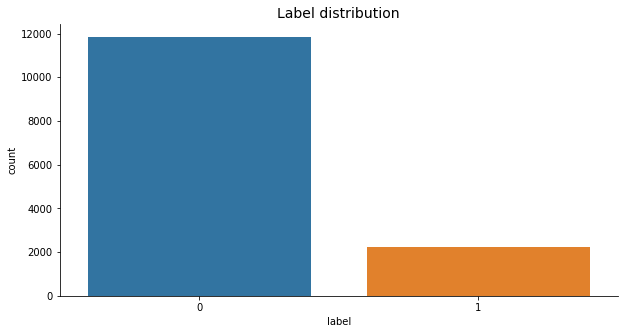

In [ ]:
print(f"Label distribution (in %):\n{round(audiobook_data['label'].value_counts() * 100 / audiobook_data.shape[0], 2)}")

# plot label distribution
plt.figure(figsize=(10,5))
sns.countplot(x="label", data=audiobook_data)
plt.title("Label distribution", size=14)
sns.despine()
plt.show()

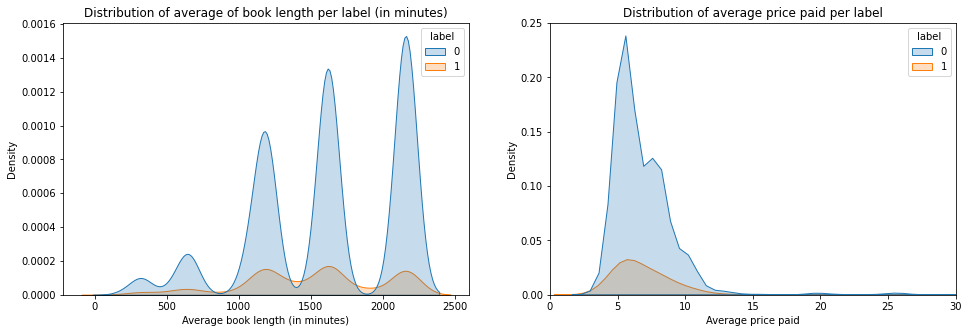

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharey=False, sharex=False)
sns.kdeplot(x="book_length_mins_avg", data=audiobook_data, hue="label", shade=True, ax=axes[0])
sns.kdeplot(x="price_paid_avg", data=audiobook_data, hue="label", shade=True, ax=axes[1])
axes[0].set_title("Distribution of average of book length per label (in minutes)")
axes[0].set_xlabel("Average book length (in minutes)")
axes[1].set_title("Distribution of average price paid per label")
axes[1].set_xlabel("Average price paid")
axes[1].set_xlim(0, 30)
plt.show()

Average Book Length and Average Price Paid for both labels are following the same distribution pattern. Nevertheless, the dataset is clearly unbalanced, as label 0 represents 84% of our dataset. This could affect the behavior of our future model. We need to balance the dataset consequently.

## Balancing the dataset

In [ ]:
# store input data into a numpy array excluding cutomer_id and label columns
unscaled_inputs = audiobook_data.iloc[:, 1:-1].values

# store target data into a separate numpy array
targets = audiobook_data.iloc[:, -1].values

In [ ]:
# When the data was collected it was actually arranged by date
# Shuffle the indices of the data, so the data is not arranged in any way when we feed it.
# Since we will be batching, we want the data to be as randomly spread out as possible
shuffled_indices = np.arange(unscaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)

# Use the shuffled indices to shuffle the inputs and targets.
unscaled_inputs = unscaled_inputs[shuffled_indices]
targets = targets[shuffled_indices]

We are going to keep as many 0s as 1s and delete the others to get a balanced dataset.

In [ ]:
# count number of 1s in targets
num_of_ones = int(np.sum(targets))
zero_targets_counter = 0
indices_to_remove = []

# once number of 0s reached number of 1s, we delete remaining rows with label 0
for i in range(targets.shape[0]):
  if targets[i] == 0:
    zero_targets_counter += 1
    if zero_targets_counter > num_of_ones:
      indices_to_remove.append(i)

unscaled_inputs_equal_priors = np.delete(unscaled_inputs, indices_to_remove, axis=0)
targets_equal_priors = np.delete(targets, indices_to_remove, axis=0)

## Standardize the inputs

In [ ]:
# center to the mean and scale to unit variance
scaled_inputs = preprocessing.scale(unscaled_inputs_equal_priors)

## Shuffle the data

In [ ]:
# shuffle data again to avoid that all 1s are stored in train set
shuffled_indices = np.arange(scaled_inputs.shape[0])
np.random.shuffle(shuffled_indices)

shuffled_inputs = scaled_inputs[shuffled_indices]
shuffled_targets = targets_equal_priors[shuffled_indices]

## Split the dataset into train, validation and test

In [ ]:
sample_count = shuffled_inputs.shape[0]

# define size of train, validation and test sets
train_samples_count = int(0.8 * sample_count)
validation_samples_count = int(0.1 * sample_count)
test_samples_count = sample_count - train_samples_count - validation_samples_count

# build train set with shuffled data
train_inputs = shuffled_inputs[:train_samples_count]
train_targets = shuffled_targets[:train_samples_count]

# build validation set with shuffled data
validation_inputs = shuffled_inputs[train_samples_count:train_samples_count + validation_samples_count]
validation_targets = shuffled_targets[train_samples_count:train_samples_count + validation_samples_count]

# build test set with shuffled data
test_inputs = shuffled_inputs[train_samples_count + validation_samples_count:]
test_targets = shuffled_targets[train_samples_count + validation_samples_count:]

# print label distribution
print(f"Train set:\nNumber of 1s: {np.sum(train_targets)} | Set size: {train_samples_count} | % of 1s: {np.sum(train_targets) / train_samples_count}")
print("-------------")
print(f"Validation set:\nNumber of 1s: {np.sum(validation_targets)} | Set size: {validation_samples_count} | % of 1s: {np.sum(validation_targets) / validation_samples_count}")
print("-------------")
print(f"Test set:\nNumber of 1s: {np.sum(test_targets)} | Set size: {test_samples_count} | % of 1s: {np.sum(test_targets) / test_samples_count}")

Train set:
Number of 1s: 1765 | Set size: 3579 | % of 1s: 0.49315451243364067
-------------
Validation set:
Number of 1s: 229 | Set size: 447 | % of 1s: 0.5123042505592841
-------------
Test set:
Number of 1s: 243 | Set size: 448 | % of 1s: 0.5424107142857143


<p>The dataset is now pretty well balanced !</p>

<p>Let's save the three datasets in .npz format to use them for our future algorithms.<br />
Each time we run this notebook, we will process the data once again (forgetting the previous preprocessing), so training, validation and test datasets will contain different samples.</p>

In [ ]:
# Save the three datasets in *.npz.
np.savez("audiobooks-data-train", inputs=train_inputs, targets=train_targets)
np.savez("audiobooks-data-validation", inputs=validation_inputs, targets=validation_targets)
np.savez("audiobooks-data-test", inputs=test_inputs, targets=test_targets)

We are going to build a Deep Learning model in a separate notebook using these .npz files.